<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[09:14:13] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


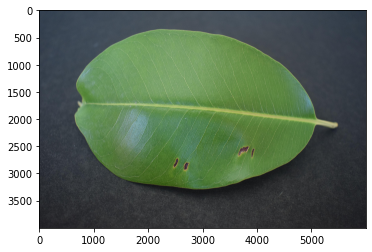

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

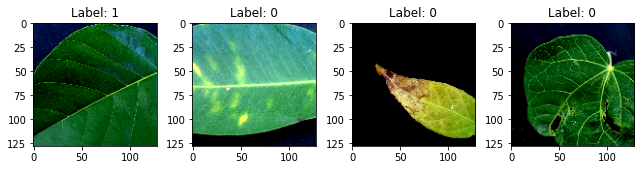

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[09:14:18] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[09:14:20] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2630645736366877 samples/sec                   batch loss = 0.27861860394477844 | accuracy = 0.65


Epoch[1] Batch[10] Speed: 1.267053380950626 samples/sec                   batch loss = 0.9388483166694641 | accuracy = 0.5


Epoch[1] Batch[15] Speed: 1.2697285016813828 samples/sec                   batch loss = 0.4685409367084503 | accuracy = 0.5333333333333333


Epoch[1] Batch[20] Speed: 1.2643236675148135 samples/sec                   batch loss = 0.5634262561798096 | accuracy = 0.6


Epoch[1] Batch[25] Speed: 1.2680600812539642 samples/sec                   batch loss = 1.8468942642211914 | accuracy = 0.58


Epoch[1] Batch[30] Speed: 1.2704799303558478 samples/sec                   batch loss = 0.9390571117401123 | accuracy = 0.5666666666666667


Epoch[1] Batch[35] Speed: 1.2671546298471232 samples/sec                   batch loss = 0.7550039887428284 | accuracy = 0.5928571428571429


Epoch[1] Batch[40] Speed: 1.2625551010873923 samples/sec                   batch loss = 0.609573483467102 | accuracy = 0.6


Epoch[1] Batch[45] Speed: 1.2670759643685636 samples/sec                   batch loss = 0.6143307089805603 | accuracy = 0.5944444444444444


Epoch[1] Batch[50] Speed: 1.261517657560978 samples/sec                   batch loss = 1.1890217065811157 | accuracy = 0.6


Epoch[1] Batch[55] Speed: 1.263136370066711 samples/sec                   batch loss = 0.45183947682380676 | accuracy = 0.6181818181818182


Epoch[1] Batch[60] Speed: 1.274036120589076 samples/sec                   batch loss = 0.6088386178016663 | accuracy = 0.6208333333333333


Epoch[1] Batch[65] Speed: 1.2684488432027041 samples/sec                   batch loss = 0.7659494280815125 | accuracy = 0.6153846153846154


Epoch[1] Batch[70] Speed: 1.2675702260147514 samples/sec                   batch loss = 0.9314092397689819 | accuracy = 0.6178571428571429


Epoch[1] Batch[75] Speed: 1.272727686511718 samples/sec                   batch loss = 0.5291913747787476 | accuracy = 0.6066666666666667


Epoch[1] Batch[80] Speed: 1.2687639583413368 samples/sec                   batch loss = 1.7987676858901978 | accuracy = 0.615625


Epoch[1] Batch[85] Speed: 1.2670643854816848 samples/sec                   batch loss = 0.4104979932308197 | accuracy = 0.6294117647058823


Epoch[1] Batch[90] Speed: 1.2710758396799813 samples/sec                   batch loss = 0.4679350256919861 | accuracy = 0.6388888888888888


Epoch[1] Batch[95] Speed: 1.2726800892723105 samples/sec                   batch loss = 0.4252268075942993 | accuracy = 0.6368421052631579


Epoch[1] Batch[100] Speed: 1.2689655798368904 samples/sec                   batch loss = 0.9587305784225464 | accuracy = 0.6275


Epoch[1] Batch[105] Speed: 1.2685583723283171 samples/sec                   batch loss = 0.3270219564437866 | accuracy = 0.6333333333333333


Epoch[1] Batch[110] Speed: 1.2680589311406836 samples/sec                   batch loss = 0.5416235327720642 | accuracy = 0.6318181818181818


Epoch[1] Batch[115] Speed: 1.2747704766441987 samples/sec                   batch loss = 0.46301695704460144 | accuracy = 0.6282608695652174


Epoch[1] Batch[120] Speed: 1.2722019008546095 samples/sec                   batch loss = 0.6412938833236694 | accuracy = 0.625


Epoch[1] Batch[125] Speed: 1.271333010774403 samples/sec                   batch loss = 0.9211161732673645 | accuracy = 0.634


Epoch[1] Batch[130] Speed: 1.2755488336104956 samples/sec                   batch loss = 0.6312064528465271 | accuracy = 0.6326923076923077


Epoch[1] Batch[135] Speed: 1.2736328076663859 samples/sec                   batch loss = 0.8922356963157654 | accuracy = 0.6259259259259259


Epoch[1] Batch[140] Speed: 1.278537317880126 samples/sec                   batch loss = 0.9078380465507507 | accuracy = 0.6321428571428571


Epoch[1] Batch[145] Speed: 1.273742460288779 samples/sec                   batch loss = 0.4279187321662903 | accuracy = 0.6362068965517241


Epoch[1] Batch[150] Speed: 1.2735886231900067 samples/sec                   batch loss = 0.3369666039943695 | accuracy = 0.64


Epoch[1] Batch[155] Speed: 1.2767255853822168 samples/sec                   batch loss = 0.9360241889953613 | accuracy = 0.6403225806451613


Epoch[1] Batch[160] Speed: 1.2745891806647835 samples/sec                   batch loss = 0.5647467374801636 | accuracy = 0.64375


Epoch[1] Batch[165] Speed: 1.2771993055389557 samples/sec                   batch loss = 1.074844241142273 | accuracy = 0.6424242424242425


Epoch[1] Batch[170] Speed: 1.2779258274800254 samples/sec                   batch loss = 0.4608319103717804 | accuracy = 0.6455882352941177


Epoch[1] Batch[175] Speed: 1.278507406590603 samples/sec                   batch loss = 0.5767905712127686 | accuracy = 0.6457142857142857


Epoch[1] Batch[180] Speed: 1.2724770927492417 samples/sec                   batch loss = 0.8001111745834351 | accuracy = 0.65


Epoch[1] Batch[185] Speed: 1.2754913281086784 samples/sec                   batch loss = 0.37894558906555176 | accuracy = 0.6581081081081082


Epoch[1] Batch[190] Speed: 1.274389640394616 samples/sec                   batch loss = 0.3507038354873657 | accuracy = 0.6644736842105263


Epoch[1] Batch[195] Speed: 1.2723721931593412 samples/sec                   batch loss = 0.4599217474460602 | accuracy = 0.6653846153846154


Epoch[1] Batch[200] Speed: 1.2722635481583509 samples/sec                   batch loss = 0.5276989936828613 | accuracy = 0.66625


Epoch[1] Batch[205] Speed: 1.2747212737049745 samples/sec                   batch loss = 0.6399328708648682 | accuracy = 0.6621951219512195


Epoch[1] Batch[210] Speed: 1.2781181029305682 samples/sec                   batch loss = 0.38882601261138916 | accuracy = 0.6642857142857143


Epoch[1] Batch[215] Speed: 1.2742278079151184 samples/sec                   batch loss = 0.7125573754310608 | accuracy = 0.6604651162790698


Epoch[1] Batch[220] Speed: 1.269296796536469 samples/sec                   batch loss = 1.3965221643447876 | accuracy = 0.6579545454545455


Epoch[1] Batch[225] Speed: 1.2733458083235838 samples/sec                   batch loss = 0.2563203275203705 | accuracy = 0.6622222222222223


Epoch[1] Batch[230] Speed: 1.2695592044581485 samples/sec                   batch loss = 0.6150794625282288 | accuracy = 0.6630434782608695


Epoch[1] Batch[235] Speed: 1.2722702052668593 samples/sec                   batch loss = 0.7036208510398865 | accuracy = 0.6606382978723404


Epoch[1] Batch[240] Speed: 1.2681543017859982 samples/sec                   batch loss = 0.6544248461723328 | accuracy = 0.6614583333333334


Epoch[1] Batch[245] Speed: 1.2692985250770046 samples/sec                   batch loss = 0.18198814988136292 | accuracy = 0.6642857142857143


Epoch[1] Batch[250] Speed: 1.2671719528766443 samples/sec                   batch loss = 0.503640353679657 | accuracy = 0.667


Epoch[1] Batch[255] Speed: 1.2626833810066627 samples/sec                   batch loss = 0.4319799542427063 | accuracy = 0.6696078431372549


Epoch[1] Batch[260] Speed: 1.2681848809394047 samples/sec                   batch loss = 0.41403767466545105 | accuracy = 0.6721153846153847


Epoch[1] Batch[265] Speed: 1.2688249850256832 samples/sec                   batch loss = 0.6230035424232483 | accuracy = 0.6716981132075471


Epoch[1] Batch[270] Speed: 1.271256137499694 samples/sec                   batch loss = 0.7109468579292297 | accuracy = 0.6703703703703704


Epoch[1] Batch[275] Speed: 1.2694462366514836 samples/sec                   batch loss = 0.7370589971542358 | accuracy = 0.6709090909090909


Epoch[1] Batch[280] Speed: 1.2700720389636158 samples/sec                   batch loss = 0.4200969934463501 | accuracy = 0.6732142857142858


Epoch[1] Batch[285] Speed: 1.2685917527399286 samples/sec                   batch loss = 0.5803266763687134 | accuracy = 0.6728070175438596


Epoch[1] Batch[290] Speed: 1.2729619592845587 samples/sec                   batch loss = 0.6382642984390259 | accuracy = 0.6698275862068965


Epoch[1] Batch[295] Speed: 1.2777824617266162 samples/sec                   batch loss = 0.39711442589759827 | accuracy = 0.6686440677966101


Epoch[1] Batch[300] Speed: 1.2705782635689302 samples/sec                   batch loss = 0.5386160016059875 | accuracy = 0.6683333333333333


Epoch[1] Batch[305] Speed: 1.2703456367819879 samples/sec                   batch loss = 0.6152992248535156 | accuracy = 0.6663934426229509


Epoch[1] Batch[310] Speed: 1.2722912383283171 samples/sec                   batch loss = 0.5275501012802124 | accuracy = 0.667741935483871


Epoch[1] Batch[315] Speed: 1.2627814614597317 samples/sec                   batch loss = 0.7472226619720459 | accuracy = 0.6666666666666666


Epoch[1] Batch[320] Speed: 1.2687334472005114 samples/sec                   batch loss = 0.9156427979469299 | accuracy = 0.66640625


Epoch[1] Batch[325] Speed: 1.264610236042714 samples/sec                   batch loss = 0.5531454682350159 | accuracy = 0.6653846153846154


Epoch[1] Batch[330] Speed: 1.2693708399075914 samples/sec                   batch loss = 0.7135201096534729 | accuracy = 0.6674242424242425


Epoch[1] Batch[335] Speed: 1.2667775645912707 samples/sec                   batch loss = 0.7193647623062134 | accuracy = 0.6656716417910448


Epoch[1] Batch[340] Speed: 1.2622404980703625 samples/sec                   batch loss = 0.4975523054599762 | accuracy = 0.6647058823529411


Epoch[1] Batch[345] Speed: 1.268851662055539 samples/sec                   batch loss = 0.8123863935470581 | accuracy = 0.6673913043478261


Epoch[1] Batch[350] Speed: 1.2744977774631099 samples/sec                   batch loss = 0.4719308018684387 | accuracy = 0.67


Epoch[1] Batch[355] Speed: 1.2669410499775644 samples/sec                   batch loss = 0.5493263006210327 | accuracy = 0.6697183098591549


Epoch[1] Batch[360] Speed: 1.2674992652874975 samples/sec                   batch loss = 0.5171827077865601 | accuracy = 0.6708333333333333


Epoch[1] Batch[365] Speed: 1.2647760228632254 samples/sec                   batch loss = 0.7826864719390869 | accuracy = 0.6705479452054794


Epoch[1] Batch[370] Speed: 1.266344422378283 samples/sec                   batch loss = 0.7320984601974487 | accuracy = 0.668918918918919


Epoch[1] Batch[375] Speed: 1.2679015769780997 samples/sec                   batch loss = 0.4032687842845917 | accuracy = 0.6706666666666666


Epoch[1] Batch[380] Speed: 1.270445873281149 samples/sec                   batch loss = 0.5815165638923645 | accuracy = 0.6736842105263158


Epoch[1] Batch[385] Speed: 1.2666717855342464 samples/sec                   batch loss = 1.3010560274124146 | accuracy = 0.672077922077922


Epoch[1] Batch[390] Speed: 1.2733605949569284 samples/sec                   batch loss = 1.0218634605407715 | accuracy = 0.675


Epoch[1] Batch[395] Speed: 1.2785833080000242 samples/sec                   batch loss = 0.9593768119812012 | accuracy = 0.6721518987341772


Epoch[1] Batch[400] Speed: 1.2732236626068276 samples/sec                   batch loss = 0.5048782229423523 | accuracy = 0.673125


Epoch[1] Batch[405] Speed: 1.2741479715053845 samples/sec                   batch loss = 0.46734511852264404 | accuracy = 0.674074074074074


Epoch[1] Batch[410] Speed: 1.274876450203634 samples/sec                   batch loss = 0.5552054047584534 | accuracy = 0.6737804878048781


Epoch[1] Batch[415] Speed: 1.27414090767454 samples/sec                   batch loss = 0.5803381204605103 | accuracy = 0.6759036144578313


Epoch[1] Batch[420] Speed: 1.2698406547228351 samples/sec                   batch loss = 0.5164923071861267 | accuracy = 0.6767857142857143


Epoch[1] Batch[425] Speed: 1.2778748233490476 samples/sec                   batch loss = 0.9383447766304016 | accuracy = 0.6747058823529412


Epoch[1] Batch[430] Speed: 1.2724419634534678 samples/sec                   batch loss = 0.5134538412094116 | accuracy = 0.675


Epoch[1] Batch[435] Speed: 1.2710223958278093 samples/sec                   batch loss = 0.42386898398399353 | accuracy = 0.6735632183908046


Epoch[1] Batch[440] Speed: 1.2744464657335786 samples/sec                   batch loss = 0.8489168286323547 | accuracy = 0.6732954545454546


Epoch[1] Batch[445] Speed: 1.2724374276693065 samples/sec                   batch loss = 0.25281059741973877 | accuracy = 0.6735955056179775


Epoch[1] Batch[450] Speed: 1.274509783067964 samples/sec                   batch loss = 0.5467944145202637 | accuracy = 0.6738888888888889


Epoch[1] Batch[455] Speed: 1.2725711986340724 samples/sec                   batch loss = 0.47286736965179443 | accuracy = 0.6741758241758242


Epoch[1] Batch[460] Speed: 1.269639139405067 samples/sec                   batch loss = 0.5854713916778564 | accuracy = 0.675


Epoch[1] Batch[465] Speed: 1.2749396165001827 samples/sec                   batch loss = 0.6320376992225647 | accuracy = 0.6741935483870968


Epoch[1] Batch[470] Speed: 1.2783129686179235 samples/sec                   batch loss = 0.43916356563568115 | accuracy = 0.673936170212766


Epoch[1] Batch[475] Speed: 1.2670913713147711 samples/sec                   batch loss = 0.3701069951057434 | accuracy = 0.6742105263157895


Epoch[1] Batch[480] Speed: 1.2634426663696556 samples/sec                   batch loss = 0.5282642245292664 | accuracy = 0.6744791666666666


Epoch[1] Batch[485] Speed: 1.2689406255826239 samples/sec                   batch loss = 0.4914668798446655 | accuracy = 0.6747422680412372


Epoch[1] Batch[490] Speed: 1.2709297704629028 samples/sec                   batch loss = 0.5094631314277649 | accuracy = 0.676530612244898


Epoch[1] Batch[495] Speed: 1.2722069173133022 samples/sec                   batch loss = 0.19367490708827972 | accuracy = 0.6782828282828283


Epoch[1] Batch[500] Speed: 1.2697113969604665 samples/sec                   batch loss = 0.7966446280479431 | accuracy = 0.6775


Epoch[1] Batch[505] Speed: 1.2717914570856832 samples/sec                   batch loss = 0.23078693449497223 | accuracy = 0.6792079207920793


Epoch[1] Batch[510] Speed: 1.2686221611381203 samples/sec                   batch loss = 0.4778749346733093 | accuracy = 0.6799019607843138


Epoch[1] Batch[515] Speed: 1.2674261103188174 samples/sec                   batch loss = 0.4353853166103363 | accuracy = 0.6800970873786408


Epoch[1] Batch[520] Speed: 1.272380588349946 samples/sec                   batch loss = 0.5908228158950806 | accuracy = 0.6807692307692308


Epoch[1] Batch[525] Speed: 1.2714278146811533 samples/sec                   batch loss = 0.8367539048194885 | accuracy = 0.6795238095238095


Epoch[1] Batch[530] Speed: 1.2698543028031803 samples/sec                   batch loss = 0.28650808334350586 | accuracy = 0.6806603773584906


Epoch[1] Batch[535] Speed: 1.2656501010236343 samples/sec                   batch loss = 0.7022405862808228 | accuracy = 0.6822429906542056


Epoch[1] Batch[540] Speed: 1.268168201218369 samples/sec                   batch loss = 0.44146597385406494 | accuracy = 0.6824074074074075


Epoch[1] Batch[545] Speed: 1.2732840560963314 samples/sec                   batch loss = 0.7393636703491211 | accuracy = 0.6825688073394496


Epoch[1] Batch[550] Speed: 1.2703402502394967 samples/sec                   batch loss = 0.5973968505859375 | accuracy = 0.6827272727272727


Epoch[1] Batch[555] Speed: 1.2698110528525839 samples/sec                   batch loss = 0.7271592020988464 | accuracy = 0.6842342342342342


Epoch[1] Batch[560] Speed: 1.273738398743846 samples/sec                   batch loss = 0.23318152129650116 | accuracy = 0.6857142857142857


Epoch[1] Batch[565] Speed: 1.277043465883466 samples/sec                   batch loss = 0.27505940198898315 | accuracy = 0.6858407079646017


Epoch[1] Batch[570] Speed: 1.269001093352485 samples/sec                   batch loss = 0.36458900570869446 | accuracy = 0.6855263157894737


Epoch[1] Batch[575] Speed: 1.2673823554273929 samples/sec                   batch loss = 1.5237295627593994 | accuracy = 0.6856521739130435


Epoch[1] Batch[580] Speed: 1.258986758709518 samples/sec                   batch loss = 1.3651317358016968 | accuracy = 0.6857758620689656


Epoch[1] Batch[585] Speed: 1.2653624884623988 samples/sec                   batch loss = 0.5253309607505798 | accuracy = 0.6858974358974359


Epoch[1] Batch[590] Speed: 1.2697779926549546 samples/sec                   batch loss = 0.6670493483543396 | accuracy = 0.6847457627118644


Epoch[1] Batch[595] Speed: 1.2644972894718634 samples/sec                   batch loss = 0.8535161018371582 | accuracy = 0.6848739495798319


Epoch[1] Batch[600] Speed: 1.2712881187352811 samples/sec                   batch loss = 0.407962828874588 | accuracy = 0.68625


Epoch[1] Batch[605] Speed: 1.2674734111269088 samples/sec                   batch loss = 0.5185942649841309 | accuracy = 0.6863636363636364


Epoch[1] Batch[610] Speed: 1.270993701703884 samples/sec                   batch loss = 0.7188681960105896 | accuracy = 0.6864754098360656


Epoch[1] Batch[615] Speed: 1.2649565406277894 samples/sec                   batch loss = 0.4918205440044403 | accuracy = 0.6853658536585366


Epoch[1] Batch[620] Speed: 1.2627668244559191 samples/sec                   batch loss = 0.602272093296051 | accuracy = 0.6850806451612903


Epoch[1] Batch[625] Speed: 1.2634293460502508 samples/sec                   batch loss = 0.5422407388687134 | accuracy = 0.6848


Epoch[1] Batch[630] Speed: 1.2652331865555038 samples/sec                   batch loss = 0.46301156282424927 | accuracy = 0.6849206349206349


Epoch[1] Batch[635] Speed: 1.2619206415050488 samples/sec                   batch loss = 0.7028571367263794 | accuracy = 0.6854330708661417


Epoch[1] Batch[640] Speed: 1.26035664095428 samples/sec                   batch loss = 0.5035275816917419 | accuracy = 0.68515625


Epoch[1] Batch[645] Speed: 1.264751614484367 samples/sec                   batch loss = 0.4173133969306946 | accuracy = 0.6856589147286821


Epoch[1] Batch[650] Speed: 1.2687479350120843 samples/sec                   batch loss = 0.7047182321548462 | accuracy = 0.6838461538461539


Epoch[1] Batch[655] Speed: 1.2651675437462035 samples/sec                   batch loss = 0.33761271834373474 | accuracy = 0.6851145038167938


Epoch[1] Batch[660] Speed: 1.2709675122250546 samples/sec                   batch loss = 0.3409103751182556 | accuracy = 0.6852272727272727


Epoch[1] Batch[665] Speed: 1.2697753017843985 samples/sec                   batch loss = 0.34858497977256775 | accuracy = 0.6853383458646617


Epoch[1] Batch[670] Speed: 1.2692171927428673 samples/sec                   batch loss = 0.5088340640068054 | accuracy = 0.6850746268656717


Epoch[1] Batch[675] Speed: 1.267987149032183 samples/sec                   batch loss = 0.4383736848831177 | accuracy = 0.6859259259259259


Epoch[1] Batch[680] Speed: 1.2755514520282656 samples/sec                   batch loss = 0.16334086656570435 | accuracy = 0.6860294117647059


Epoch[1] Batch[685] Speed: 1.2709241864129446 samples/sec                   batch loss = 0.8349304795265198 | accuracy = 0.6868613138686132


Epoch[1] Batch[690] Speed: 1.2688261365289866 samples/sec                   batch loss = 0.9002329707145691 | accuracy = 0.6865942028985508


Epoch[1] Batch[695] Speed: 1.2702743649788875 samples/sec                   batch loss = 0.4293818175792694 | accuracy = 0.6874100719424461


Epoch[1] Batch[700] Speed: 1.270566235695522 samples/sec                   batch loss = 0.541162371635437 | accuracy = 0.6885714285714286


Epoch[1] Batch[705] Speed: 1.2699764757997165 samples/sec                   batch loss = 0.2567827105522156 | accuracy = 0.6893617021276596


Epoch[1] Batch[710] Speed: 1.268741218766904 samples/sec                   batch loss = 0.5693221092224121 | accuracy = 0.6894366197183098


Epoch[1] Batch[715] Speed: 1.2722244752302745 samples/sec                   batch loss = 0.5635916590690613 | accuracy = 0.6895104895104895


Epoch[1] Batch[720] Speed: 1.2740785945325364 samples/sec                   batch loss = 0.2096235156059265 | accuracy = 0.6895833333333333


Epoch[1] Batch[725] Speed: 1.273623525771471 samples/sec                   batch loss = 0.6236613988876343 | accuracy = 0.6893103448275862


Epoch[1] Batch[730] Speed: 1.2690778861278798 samples/sec                   batch loss = 1.2797119617462158 | accuracy = 0.6886986301369863


Epoch[1] Batch[735] Speed: 1.2706304190625584 samples/sec                   batch loss = 0.8652753829956055 | accuracy = 0.6880952380952381


Epoch[1] Batch[740] Speed: 1.272325104948217 samples/sec                   batch loss = 0.41173288226127625 | accuracy = 0.6888513513513513


Epoch[1] Batch[745] Speed: 1.2685760215224908 samples/sec                   batch loss = 0.2969242334365845 | accuracy = 0.6895973154362416


Epoch[1] Batch[750] Speed: 1.2661994385232125 samples/sec                   batch loss = 0.5547626614570618 | accuracy = 0.69


Epoch[1] Batch[755] Speed: 1.2686013451371652 samples/sec                   batch loss = 0.41362515091896057 | accuracy = 0.6894039735099338


Epoch[1] Batch[760] Speed: 1.275298969648929 samples/sec                   batch loss = 0.5127967000007629 | accuracy = 0.6898026315789474


Epoch[1] Batch[765] Speed: 1.2684263067185735 samples/sec                   batch loss = 0.6070109009742737 | accuracy = 0.688562091503268


Epoch[1] Batch[770] Speed: 1.2697648267183477 samples/sec                   batch loss = 0.6036970019340515 | accuracy = 0.6892857142857143


Epoch[1] Batch[775] Speed: 1.2659258086631764 samples/sec                   batch loss = 0.618720293045044 | accuracy = 0.6896774193548387


Epoch[1] Batch[780] Speed: 1.2281755674757646 samples/sec                   batch loss = 0.7788079977035522 | accuracy = 0.6897435897435897


Epoch[1] Batch[785] Speed: 1.2658294358104023 samples/sec                   batch loss = 0.7411993741989136 | accuracy = 0.6882165605095542


[Epoch 1] training: accuracy=0.6881345177664975
[Epoch 1] time cost: 648.0845429897308
[Epoch 1] validation: validation accuracy=0.7533333333333333


Epoch[2] Batch[5] Speed: 1.2715868163830903 samples/sec                   batch loss = 0.3359299898147583 | accuracy = 0.8


Epoch[2] Batch[10] Speed: 1.2697067845303467 samples/sec                   batch loss = 0.24738606810569763 | accuracy = 0.75


Epoch[2] Batch[15] Speed: 1.2739142293256034 samples/sec                   batch loss = 0.23586440086364746 | accuracy = 0.7666666666666667


Epoch[2] Batch[20] Speed: 1.2794794110337033 samples/sec                   batch loss = 0.5304234623908997 | accuracy = 0.7875


Epoch[2] Batch[25] Speed: 1.2718382165596405 samples/sec                   batch loss = 0.5545074939727783 | accuracy = 0.77


Epoch[2] Batch[30] Speed: 1.2711566399103649 samples/sec                   batch loss = 0.5371958613395691 | accuracy = 0.775


Epoch[2] Batch[35] Speed: 1.273842459825924 samples/sec                   batch loss = 0.5827645063400269 | accuracy = 0.7714285714285715


Epoch[2] Batch[40] Speed: 1.2761566917990055 samples/sec                   batch loss = 0.531006932258606 | accuracy = 0.75625


Epoch[2] Batch[45] Speed: 1.272789191665231 samples/sec                   batch loss = 0.8354012370109558 | accuracy = 0.7666666666666667


Epoch[2] Batch[50] Speed: 1.2743645691560803 samples/sec                   batch loss = 0.41779279708862305 | accuracy = 0.755


Epoch[2] Batch[55] Speed: 1.2664886745951849 samples/sec                   batch loss = 0.6265466213226318 | accuracy = 0.7363636363636363


Epoch[2] Batch[60] Speed: 1.2736061225831439 samples/sec                   batch loss = 0.5347110629081726 | accuracy = 0.7416666666666667


Epoch[2] Batch[65] Speed: 1.2738629645720774 samples/sec                   batch loss = 0.2625320553779602 | accuracy = 0.75


Epoch[2] Batch[70] Speed: 1.2667196995367778 samples/sec                   batch loss = 0.32159096002578735 | accuracy = 0.7535714285714286


Epoch[2] Batch[75] Speed: 1.2696605659872173 samples/sec                   batch loss = 0.36190956830978394 | accuracy = 0.7633333333333333


Epoch[2] Batch[80] Speed: 1.268588299512435 samples/sec                   batch loss = 0.3847198188304901 | accuracy = 0.765625


Epoch[2] Batch[85] Speed: 1.2626335862983178 samples/sec                   batch loss = 0.45741763710975647 | accuracy = 0.7617647058823529


Epoch[2] Batch[90] Speed: 1.2696267449859207 samples/sec                   batch loss = 0.655010461807251 | accuracy = 0.7527777777777778


Epoch[2] Batch[95] Speed: 1.2731982507390405 samples/sec                   batch loss = 0.6225780248641968 | accuracy = 0.7473684210526316


Epoch[2] Batch[100] Speed: 1.2745536441759757 samples/sec                   batch loss = 0.5721419453620911 | accuracy = 0.7475


Epoch[2] Batch[105] Speed: 1.2698132633341732 samples/sec                   batch loss = 0.5015258193016052 | accuracy = 0.75


Epoch[2] Batch[110] Speed: 1.2751165542001541 samples/sec                   batch loss = 0.16983304917812347 | accuracy = 0.759090909090909


Epoch[2] Batch[115] Speed: 1.2743776370530802 samples/sec                   batch loss = 0.2754652500152588 | accuracy = 0.7565217391304347


Epoch[2] Batch[120] Speed: 1.2632773240159578 samples/sec                   batch loss = 1.2187994718551636 | accuracy = 0.75


Epoch[2] Batch[125] Speed: 1.2689485916417624 samples/sec                   batch loss = 0.593819797039032 | accuracy = 0.748


Epoch[2] Batch[130] Speed: 1.2708252220828813 samples/sec                   batch loss = 0.2436962127685547 | accuracy = 0.7480769230769231


Epoch[2] Batch[135] Speed: 1.2687838201555175 samples/sec                   batch loss = 0.6161733865737915 | accuracy = 0.7388888888888889


Epoch[2] Batch[140] Speed: 1.2619842391277776 samples/sec                   batch loss = 0.8096962571144104 | accuracy = 0.7357142857142858


Epoch[2] Batch[145] Speed: 1.2655063261301402 samples/sec                   batch loss = 0.32727766036987305 | accuracy = 0.7379310344827587


Epoch[2] Batch[150] Speed: 1.274637211329956 samples/sec                   batch loss = 0.15061300992965698 | accuracy = 0.735


Epoch[2] Batch[155] Speed: 1.2795572820835686 samples/sec                   batch loss = 0.3624744415283203 | accuracy = 0.7370967741935484


Epoch[2] Batch[160] Speed: 1.2765457726350367 samples/sec                   batch loss = 0.6818647980690002 | accuracy = 0.740625


Epoch[2] Batch[165] Speed: 1.2796175947480295 samples/sec                   batch loss = 0.48450586199760437 | accuracy = 0.7393939393939394


Epoch[2] Batch[170] Speed: 1.278924634674168 samples/sec                   batch loss = 0.4009803831577301 | accuracy = 0.7441176470588236


Epoch[2] Batch[175] Speed: 1.276175329643322 samples/sec                   batch loss = 0.39189910888671875 | accuracy = 0.7485714285714286


Epoch[2] Batch[180] Speed: 1.2773486673093553 samples/sec                   batch loss = 0.36794668436050415 | accuracy = 0.7486111111111111


Epoch[2] Batch[185] Speed: 1.2744977774631099 samples/sec                   batch loss = 0.5574967861175537 | accuracy = 0.7486486486486487


Epoch[2] Batch[190] Speed: 1.280565581829316 samples/sec                   batch loss = 0.31594786047935486 | accuracy = 0.75


Epoch[2] Batch[195] Speed: 1.2780185018924364 samples/sec                   batch loss = 0.46432265639305115 | accuracy = 0.75


Epoch[2] Batch[200] Speed: 1.2693163869382162 samples/sec                   batch loss = 0.48160552978515625 | accuracy = 0.75


Epoch[2] Batch[205] Speed: 1.2640716098611535 samples/sec                   batch loss = 0.3004794716835022 | accuracy = 0.75


Epoch[2] Batch[210] Speed: 1.2687312404767923 samples/sec                   batch loss = 0.5405035018920898 | accuracy = 0.7511904761904762


Epoch[2] Batch[215] Speed: 1.2652445411626405 samples/sec                   batch loss = 0.4386104941368103 | accuracy = 0.75


Epoch[2] Batch[220] Speed: 1.2626822406258886 samples/sec                   batch loss = 0.6121488213539124 | accuracy = 0.7488636363636364


Epoch[2] Batch[225] Speed: 1.2646677178668706 samples/sec                   batch loss = 0.4436818063259125 | accuracy = 0.7455555555555555


Epoch[2] Batch[230] Speed: 1.2653195439387623 samples/sec                   batch loss = 1.1034222841262817 | accuracy = 0.7467391304347826


Epoch[2] Batch[235] Speed: 1.26499535915468 samples/sec                   batch loss = 0.5061362981796265 | accuracy = 0.747872340425532


Epoch[2] Batch[240] Speed: 1.2725555616151456 samples/sec                   batch loss = 0.47061121463775635 | accuracy = 0.7479166666666667


Epoch[2] Batch[245] Speed: 1.277320756564314 samples/sec                   batch loss = 0.21276454627513885 | accuracy = 0.75


Epoch[2] Batch[250] Speed: 1.2753423034117115 samples/sec                   batch loss = 0.8487439155578613 | accuracy = 0.748


Epoch[2] Batch[255] Speed: 1.2710203737162402 samples/sec                   batch loss = 0.29314082860946655 | accuracy = 0.7490196078431373


Epoch[2] Batch[260] Speed: 1.2726205253290475 samples/sec                   batch loss = 0.47833651304244995 | accuracy = 0.7490384615384615


Epoch[2] Batch[265] Speed: 1.26687264692026 samples/sec                   batch loss = 0.39058035612106323 | accuracy = 0.75


Epoch[2] Batch[270] Speed: 1.2667566177875196 samples/sec                   batch loss = 0.47172147035598755 | accuracy = 0.75


Epoch[2] Batch[275] Speed: 1.2656381662733083 samples/sec                   batch loss = 0.3896150588989258 | accuracy = 0.7518181818181818


Epoch[2] Batch[280] Speed: 1.263190103860793 samples/sec                   batch loss = 0.3120366930961609 | accuracy = 0.7517857142857143


Epoch[2] Batch[285] Speed: 1.2666985633722785 samples/sec                   batch loss = 0.6042633652687073 | accuracy = 0.7535087719298246


Epoch[2] Batch[290] Speed: 1.2675368993395852 samples/sec                   batch loss = 0.39096492528915405 | accuracy = 0.7525862068965518


Epoch[2] Batch[295] Speed: 1.262513581986435 samples/sec                   batch loss = 0.30337104201316833 | accuracy = 0.7533898305084745


Epoch[2] Batch[300] Speed: 1.2665584704319741 samples/sec                   batch loss = 0.28176090121269226 | accuracy = 0.7566666666666667


Epoch[2] Batch[305] Speed: 1.2665556019583384 samples/sec                   batch loss = 0.19655343890190125 | accuracy = 0.7557377049180328


Epoch[2] Batch[310] Speed: 1.262724436086434 samples/sec                   batch loss = 0.4362766742706299 | accuracy = 0.757258064516129


Epoch[2] Batch[315] Speed: 1.2707834460488665 samples/sec                   batch loss = 0.2923181653022766 | accuracy = 0.7579365079365079


Epoch[2] Batch[320] Speed: 1.2662394801850827 samples/sec                   batch loss = 0.20555855333805084 | accuracy = 0.76015625


Epoch[2] Batch[325] Speed: 1.2640941823558776 samples/sec                   batch loss = 0.4287458062171936 | accuracy = 0.7592307692307693


Epoch[2] Batch[330] Speed: 1.2620896164619442 samples/sec                   batch loss = 0.2408754527568817 | accuracy = 0.759090909090909


Epoch[2] Batch[335] Speed: 1.265786746084954 samples/sec                   batch loss = 0.5619822144508362 | accuracy = 0.758955223880597


Epoch[2] Batch[340] Speed: 1.2696379864256355 samples/sec                   batch loss = 0.18446208536624908 | accuracy = 0.7610294117647058


Epoch[2] Batch[345] Speed: 1.2712116361685628 samples/sec                   batch loss = 0.23343156278133392 | accuracy = 0.7615942028985507


Epoch[2] Batch[350] Speed: 1.2734247709921869 samples/sec                   batch loss = 0.2648056447505951 | accuracy = 0.7635714285714286


Epoch[2] Batch[355] Speed: 1.2726739105814149 samples/sec                   batch loss = 0.4831921458244324 | accuracy = 0.7612676056338028


Epoch[2] Batch[360] Speed: 1.2645103463984153 samples/sec                   batch loss = 0.23628665506839752 | accuracy = 0.7604166666666666


Epoch[2] Batch[365] Speed: 1.2668579149208297 samples/sec                   batch loss = 0.4782833755016327 | accuracy = 0.7616438356164383


Epoch[2] Batch[370] Speed: 1.2710895143245937 samples/sec                   batch loss = 0.372570276260376 | accuracy = 0.7601351351351351


Epoch[2] Batch[375] Speed: 1.268881219211478 samples/sec                   batch loss = 0.4150931239128113 | accuracy = 0.7606666666666667


Epoch[2] Batch[380] Speed: 1.267506734463591 samples/sec                   batch loss = 0.3122687041759491 | accuracy = 0.7611842105263158


Epoch[2] Batch[385] Speed: 1.268342401319174 samples/sec                   batch loss = 0.3104097247123718 | accuracy = 0.7597402597402597


Epoch[2] Batch[390] Speed: 1.269008868198141 samples/sec                   batch loss = 0.9758711457252502 | accuracy = 0.7564102564102564


Epoch[2] Batch[395] Speed: 1.2605448019970102 samples/sec                   batch loss = 0.30442777276039124 | accuracy = 0.7575949367088608


Epoch[2] Batch[400] Speed: 1.2673533467381841 samples/sec                   batch loss = 0.45015841722488403 | accuracy = 0.75875


Epoch[2] Batch[405] Speed: 1.2641135172433955 samples/sec                   batch loss = 0.4096384644508362 | accuracy = 0.7592592592592593


Epoch[2] Batch[410] Speed: 1.2604114641650184 samples/sec                   batch loss = 0.516392171382904 | accuracy = 0.7591463414634146


Epoch[2] Batch[415] Speed: 1.268015995070998 samples/sec                   batch loss = 0.6253259181976318 | accuracy = 0.7590361445783133


Epoch[2] Batch[420] Speed: 1.2692087432279353 samples/sec                   batch loss = 0.2546958923339844 | accuracy = 0.7577380952380952


Epoch[2] Batch[425] Speed: 1.2718848830501859 samples/sec                   batch loss = 0.3941781222820282 | accuracy = 0.7576470588235295


Epoch[2] Batch[430] Speed: 1.2715401717621977 samples/sec                   batch loss = 0.22130759060382843 | accuracy = 0.7587209302325582


Epoch[2] Batch[435] Speed: 1.2705356378121138 samples/sec                   batch loss = 0.24935565888881683 | accuracy = 0.7586206896551724


Epoch[2] Batch[440] Speed: 1.2730536253182119 samples/sec                   batch loss = 0.33001047372817993 | accuracy = 0.7585227272727273


Epoch[2] Batch[445] Speed: 1.2673746004992381 samples/sec                   batch loss = 0.712272047996521 | accuracy = 0.7584269662921348


Epoch[2] Batch[450] Speed: 1.267910392378337 samples/sec                   batch loss = 0.41330939531326294 | accuracy = 0.7583333333333333


Epoch[2] Batch[455] Speed: 1.2733284127240125 samples/sec                   batch loss = 0.25914686918258667 | accuracy = 0.7576923076923077


Epoch[2] Batch[460] Speed: 1.268219392100086 samples/sec                   batch loss = 0.4358912408351898 | accuracy = 0.7581521739130435


Epoch[2] Batch[465] Speed: 1.2664647736796122 samples/sec                   batch loss = 0.7281525135040283 | accuracy = 0.7559139784946236


Epoch[2] Batch[470] Speed: 1.2704694436608919 samples/sec                   batch loss = 0.472835510969162 | accuracy = 0.7558510638297873


Epoch[2] Batch[475] Speed: 1.2719443781494946 samples/sec                   batch loss = 0.48653125762939453 | accuracy = 0.7557894736842106


Epoch[2] Batch[480] Speed: 1.2718511362782658 samples/sec                   batch loss = 0.7076472043991089 | accuracy = 0.7557291666666667


Epoch[2] Batch[485] Speed: 1.2691599686817987 samples/sec                   batch loss = 1.039602518081665 | accuracy = 0.756701030927835


Epoch[2] Batch[490] Speed: 1.2736960441758898 samples/sec                   batch loss = 0.32057392597198486 | accuracy = 0.7556122448979592


Epoch[2] Batch[495] Speed: 1.2729611866027664 samples/sec                   batch loss = 0.533480703830719 | accuracy = 0.7550505050505051


Epoch[2] Batch[500] Speed: 1.265162678053311 samples/sec                   batch loss = 0.3560679256916046 | accuracy = 0.7555


Epoch[2] Batch[505] Speed: 1.2727987510846759 samples/sec                   batch loss = 0.4321975111961365 | accuracy = 0.7569306930693069


Epoch[2] Batch[510] Speed: 1.2767830079013107 samples/sec                   batch loss = 0.260522723197937 | accuracy = 0.7568627450980392


Epoch[2] Batch[515] Speed: 1.2728006822979578 samples/sec                   batch loss = 1.1196404695510864 | accuracy = 0.7548543689320388


Epoch[2] Batch[520] Speed: 1.2726121269719375 samples/sec                   batch loss = 0.5930833220481873 | accuracy = 0.75625


Epoch[2] Batch[525] Speed: 1.2801544131566773 samples/sec                   batch loss = 0.24336276948451996 | accuracy = 0.7557142857142857


Epoch[2] Batch[530] Speed: 1.2774151912154073 samples/sec                   batch loss = 0.4061209559440613 | accuracy = 0.7556603773584906


Epoch[2] Batch[535] Speed: 1.2773937938815323 samples/sec                   batch loss = 0.23115049302577972 | accuracy = 0.7565420560747663


Epoch[2] Batch[540] Speed: 1.2747481023958225 samples/sec                   batch loss = 1.0689435005187988 | accuracy = 0.7574074074074074


Epoch[2] Batch[545] Speed: 1.275635538047505 samples/sec                   batch loss = 0.5163573026657104 | accuracy = 0.7559633027522936


Epoch[2] Batch[550] Speed: 1.2746814685946675 samples/sec                   batch loss = 0.7359707951545715 | accuracy = 0.7559090909090909


Epoch[2] Batch[555] Speed: 1.2760981608587085 samples/sec                   batch loss = 0.5272091031074524 | accuracy = 0.7567567567567568


Epoch[2] Batch[560] Speed: 1.267028023411132 samples/sec                   batch loss = 0.5053505301475525 | accuracy = 0.7558035714285715


Epoch[2] Batch[565] Speed: 1.2727718112704818 samples/sec                   batch loss = 0.31228283047676086 | accuracy = 0.7553097345132743


Epoch[2] Batch[570] Speed: 1.2680636274497132 samples/sec                   batch loss = 0.38199126720428467 | accuracy = 0.7557017543859649


Epoch[2] Batch[575] Speed: 1.2717039248809152 samples/sec                   batch loss = 1.3320319652557373 | accuracy = 0.7547826086956522


Epoch[2] Batch[580] Speed: 1.2721200995724269 samples/sec                   batch loss = 1.1288807392120361 | accuracy = 0.753448275862069


Epoch[2] Batch[585] Speed: 1.2738078353851774 samples/sec                   batch loss = 0.8418422341346741 | accuracy = 0.7534188034188034


Epoch[2] Batch[590] Speed: 1.269145759479815 samples/sec                   batch loss = 0.7472354173660278 | accuracy = 0.7533898305084745


Epoch[2] Batch[595] Speed: 1.2794326734391763 samples/sec                   batch loss = 0.8556106686592102 | accuracy = 0.7525210084033613


Epoch[2] Batch[600] Speed: 1.2722662495852883 samples/sec                   batch loss = 0.7956037521362305 | accuracy = 0.7520833333333333


Epoch[2] Batch[605] Speed: 1.2725805617244068 samples/sec                   batch loss = 0.29057610034942627 | accuracy = 0.7516528925619834


Epoch[2] Batch[610] Speed: 1.2696568186852453 samples/sec                   batch loss = 0.3609149754047394 | accuracy = 0.7508196721311475


Epoch[2] Batch[615] Speed: 1.2723732546141042 samples/sec                   batch loss = 0.47966620326042175 | accuracy = 0.7504065040650406


Epoch[2] Batch[620] Speed: 1.269022786369644 samples/sec                   batch loss = 0.674737274646759 | accuracy = 0.7495967741935484


Epoch[2] Batch[625] Speed: 1.2798707161843699 samples/sec                   batch loss = 0.6569093465805054 | accuracy = 0.7484


Epoch[2] Batch[630] Speed: 1.271440244290415 samples/sec                   batch loss = 0.3340967297554016 | accuracy = 0.7484126984126984


Epoch[2] Batch[635] Speed: 1.2707659278842613 samples/sec                   batch loss = 0.3946938216686249 | accuracy = 0.7480314960629921


Epoch[2] Batch[640] Speed: 1.2772885683345534 samples/sec                   batch loss = 0.5233708024024963 | accuracy = 0.74765625


Epoch[2] Batch[645] Speed: 1.2720278928159137 samples/sec                   batch loss = 0.7606532573699951 | accuracy = 0.7472868217054264


Epoch[2] Batch[650] Speed: 1.2730621261039936 samples/sec                   batch loss = 0.683090090751648 | accuracy = 0.7473076923076923


Epoch[2] Batch[655] Speed: 1.2738289193177157 samples/sec                   batch loss = 0.7224904894828796 | accuracy = 0.7465648854961832


Epoch[2] Batch[660] Speed: 1.2773731753107205 samples/sec                   batch loss = 0.3288944363594055 | accuracy = 0.7458333333333333


Epoch[2] Batch[665] Speed: 1.2795680169315398 samples/sec                   batch loss = 0.43772509694099426 | accuracy = 0.7462406015037594


Epoch[2] Batch[670] Speed: 1.274587340852418 samples/sec                   batch loss = 0.9572117328643799 | accuracy = 0.7458955223880597


Epoch[2] Batch[675] Speed: 1.2727793427165937 samples/sec                   batch loss = 0.38540518283843994 | accuracy = 0.7466666666666667


Epoch[2] Batch[680] Speed: 1.2730543981122282 samples/sec                   batch loss = 0.6281952857971191 | accuracy = 0.7459558823529412


Epoch[2] Batch[685] Speed: 1.2751811981258871 samples/sec                   batch loss = 0.4205325245857239 | accuracy = 0.7463503649635036


Epoch[2] Batch[690] Speed: 1.2744362038834671 samples/sec                   batch loss = 0.5007017850875854 | accuracy = 0.7463768115942029


Epoch[2] Batch[695] Speed: 1.2767362727695148 samples/sec                   batch loss = 0.2928958833217621 | accuracy = 0.746043165467626


Epoch[2] Batch[700] Speed: 1.2776153882706716 samples/sec                   batch loss = 0.5571310520172119 | accuracy = 0.7475


Epoch[2] Batch[705] Speed: 1.2703635281259573 samples/sec                   batch loss = 0.5101125836372375 | accuracy = 0.7464539007092199


Epoch[2] Batch[710] Speed: 1.2784916233472106 samples/sec                   batch loss = 0.3778776228427887 | accuracy = 0.7468309859154929


Epoch[2] Batch[715] Speed: 1.2720290501400602 samples/sec                   batch loss = 0.6133022308349609 | accuracy = 0.7465034965034965


Epoch[2] Batch[720] Speed: 1.2734133657421984 samples/sec                   batch loss = 0.4530816674232483 | accuracy = 0.7461805555555555


Epoch[2] Batch[725] Speed: 1.26818651059085 samples/sec                   batch loss = 0.4170644283294678 | accuracy = 0.7455172413793103


Epoch[2] Batch[730] Speed: 1.2763623206443793 samples/sec                   batch loss = 0.4454779326915741 | accuracy = 0.7462328767123287


Epoch[2] Batch[735] Speed: 1.2695279826032184 samples/sec                   batch loss = 0.360786110162735 | accuracy = 0.7459183673469387


Epoch[2] Batch[740] Speed: 1.264525786323746 samples/sec                   batch loss = 0.8386765718460083 | accuracy = 0.7445945945945946


Epoch[2] Batch[745] Speed: 1.2766457271156 samples/sec                   batch loss = 0.6411741375923157 | accuracy = 0.7432885906040269


Epoch[2] Batch[750] Speed: 1.2698663172012103 samples/sec                   batch loss = 0.12348534911870956 | accuracy = 0.7426666666666667


Epoch[2] Batch[755] Speed: 1.2740312831897318 samples/sec                   batch loss = 0.7273723483085632 | accuracy = 0.743046357615894


Epoch[2] Batch[760] Speed: 1.2770497842813082 samples/sec                   batch loss = 0.6530203223228455 | accuracy = 0.7421052631578947


Epoch[2] Batch[765] Speed: 1.272001178502221 samples/sec                   batch loss = 0.3252471387386322 | accuracy = 0.742483660130719


Epoch[2] Batch[770] Speed: 1.2729960548025447 samples/sec                   batch loss = 0.6573250889778137 | accuracy = 0.7418831168831169


Epoch[2] Batch[775] Speed: 1.2722072067255876 samples/sec                   batch loss = 0.8888554573059082 | accuracy = 0.7429032258064516


Epoch[2] Batch[780] Speed: 1.2759714107596234 samples/sec                   batch loss = 0.502480685710907 | accuracy = 0.7426282051282052


Epoch[2] Batch[785] Speed: 1.270366894833042 samples/sec                   batch loss = 0.2928942143917084 | accuracy = 0.7426751592356687


[Epoch 2] training: accuracy=0.7427030456852792
[Epoch 2] time cost: 637.5346338748932
[Epoch 2] validation: validation accuracy=0.7822222222222223


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7755555555555556

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)